In [28]:
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import os
import pandas as pd

import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

%load_ext autoreload
%autoreload 2

/Users/tong/Envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/tong/Envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [86]:
def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

In [305]:
tf.contrib.layers.l2_regularizer?

In [321]:
def generate_training_data(data):
    inputs = data['observations']
    outputs = np.squeeze(data['actions'], axis=1)
    input_dim = inputs.shape[-1]
    output_dim = outputs.shape[-1]
    return inputs, outputs, input_dim, output_dim

def create_model(input_dim, output_dim, reg=1e-6):
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, input_dim])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, output_dim])

    layer = tf.layers.dense(input_ph, 64, 
                            activation=tf.nn.relu,
                            kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                            name='hidden_layer_1'
                           )
    layer = tf.layers.dense(layer, 128, 
                            activation=tf.nn.relu,
                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                            name='hidden_layer_2'
                           ) 
    layer = tf.layers.dense(layer, 64, 
                            activation=tf.nn.relu,
                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                            name='hidden_layer_3'
                           ) 
    layer = tf.layers.dense(layer, output_dim,
                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                            name='output_layer'                            
                           )
    output_pred = layer                         
    return input_ph, output_ph, output_pred

In [344]:
envname = 'Hopper-v2'
batch_size = 128
learning_rate=.001

train_dir = '/tmp/cs294_hw1/behavior_cloning'
rollouts_data_dir = 'expert_data/'

checkpoint_dir = os.path.join(train_dir, envname)
if not tf.gfile.Exists(checkpoint_dir):
    tf.gfile.MakeDirs(checkpoint_dir)
model_path = os.path.join(checkpoint_dir, 'model.ckpt')
    
rollouts_data_filename = os.path.join(rollouts_data_dir, envname + '.pkl')
with open(rollouts_data_filename, 'rb') as file:
    data = pickle.load(file) 
inputs, outputs, input_dim, output_dim = generate_training_data(data)

In [345]:
sess = tf_reset()

input_ph, output_ph, output_pred = create_model(input_dim, output_dim)

loss = tf.losses.mean_squared_error(output_ph, output_pred)
loss += tf.losses.get_regularization_loss()
opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

for training_step in range(20000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size)
    input_batch = inputs[indices]
    output_batch = outputs[indices]
    
    _, loss_run = sess.run([opt, loss], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    if training_step % 1000 == 0:
        print('{0:05d} loss: {1:.4f}'.format(training_step, loss_run))
        saver.save(sess, model_path)

00000 loss: 2.159
01000 loss: 0.009
02000 loss: 0.004
03000 loss: 0.003
04000 loss: 0.003
05000 loss: 0.003
06000 loss: 0.001
07000 loss: 0.004
08000 loss: 0.002
09000 loss: 0.001
10000 loss: 0.002
11000 loss: 0.001
12000 loss: 0.001
13000 loss: 0.001
14000 loss: 0.001
15000 loss: 0.001
16000 loss: 0.001
17000 loss: 0.001
18000 loss: 0.001
19000 loss: 0.001


In [350]:
sess = tf_reset()
input_ph, output_ph, output_pred = create_model(input_dim, output_dim)
saver = tf.train.Saver()
saver.restore(sess, model_path)

INFO:tensorflow:Restoring parameters from /tmp/cs294_hw1/behavior_cloning/Hopper-v2/model.ckpt


In [356]:
import gym
env = gym.make(envname)

/Users/tong/Envs/tf/lib/python3.6/site-packages/gym/envs/registration.py:14: DeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Users/tong/Envs/tf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [358]:
obs = env.reset()

In [366]:
num_rollouts = 1
max_steps = env.spec.timestep_limit

returns = []
observations = []
actions = []
for i in range(num_rollouts):
    print('iter', i)
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    while not done:
        action = sess.run([output_pred], feed_dict={input_ph: obs[None, :]})[0]
        observations.append(obs)
        actions.append(action)
        obs, r, done, _ = env.step(action)
        totalr += r
        steps += 1
        if True:
            env.render()
        if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
        if steps >= max_steps:
            break
    returns.append(totalr)

print('returns', returns)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

iter 0
Creating window glfw
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [3782.6966728594875]
mean return 3782.6966728594875
std of return 0.0


In [361]:
action = sess.run([output_pred], feed_dict={input_ph: obs[None, :]})

In [367]:
returns

[3782.6966728594875]

In [24]:
env = gym.make('Humanoid-v2')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [26]:
env.observation_space

Box(376,)

In [30]:
r = np.load('result/Humanoid-v2_dagger_learning_curve.npy')

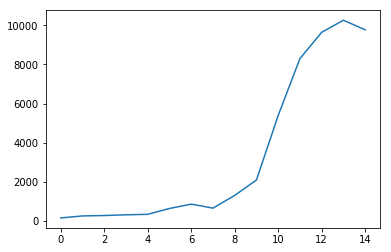

In [35]:
plt.plot(r.reshape(15, 15).mean(axis=1))